<a href="https://colab.research.google.com/github/DreamFactory100/GNN/blob/main/1_GNN_Intro_Karate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# torch_geometric, torch-sparse, torch-scatter 설치
# 
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Zachary's karate club 그래프 데이터


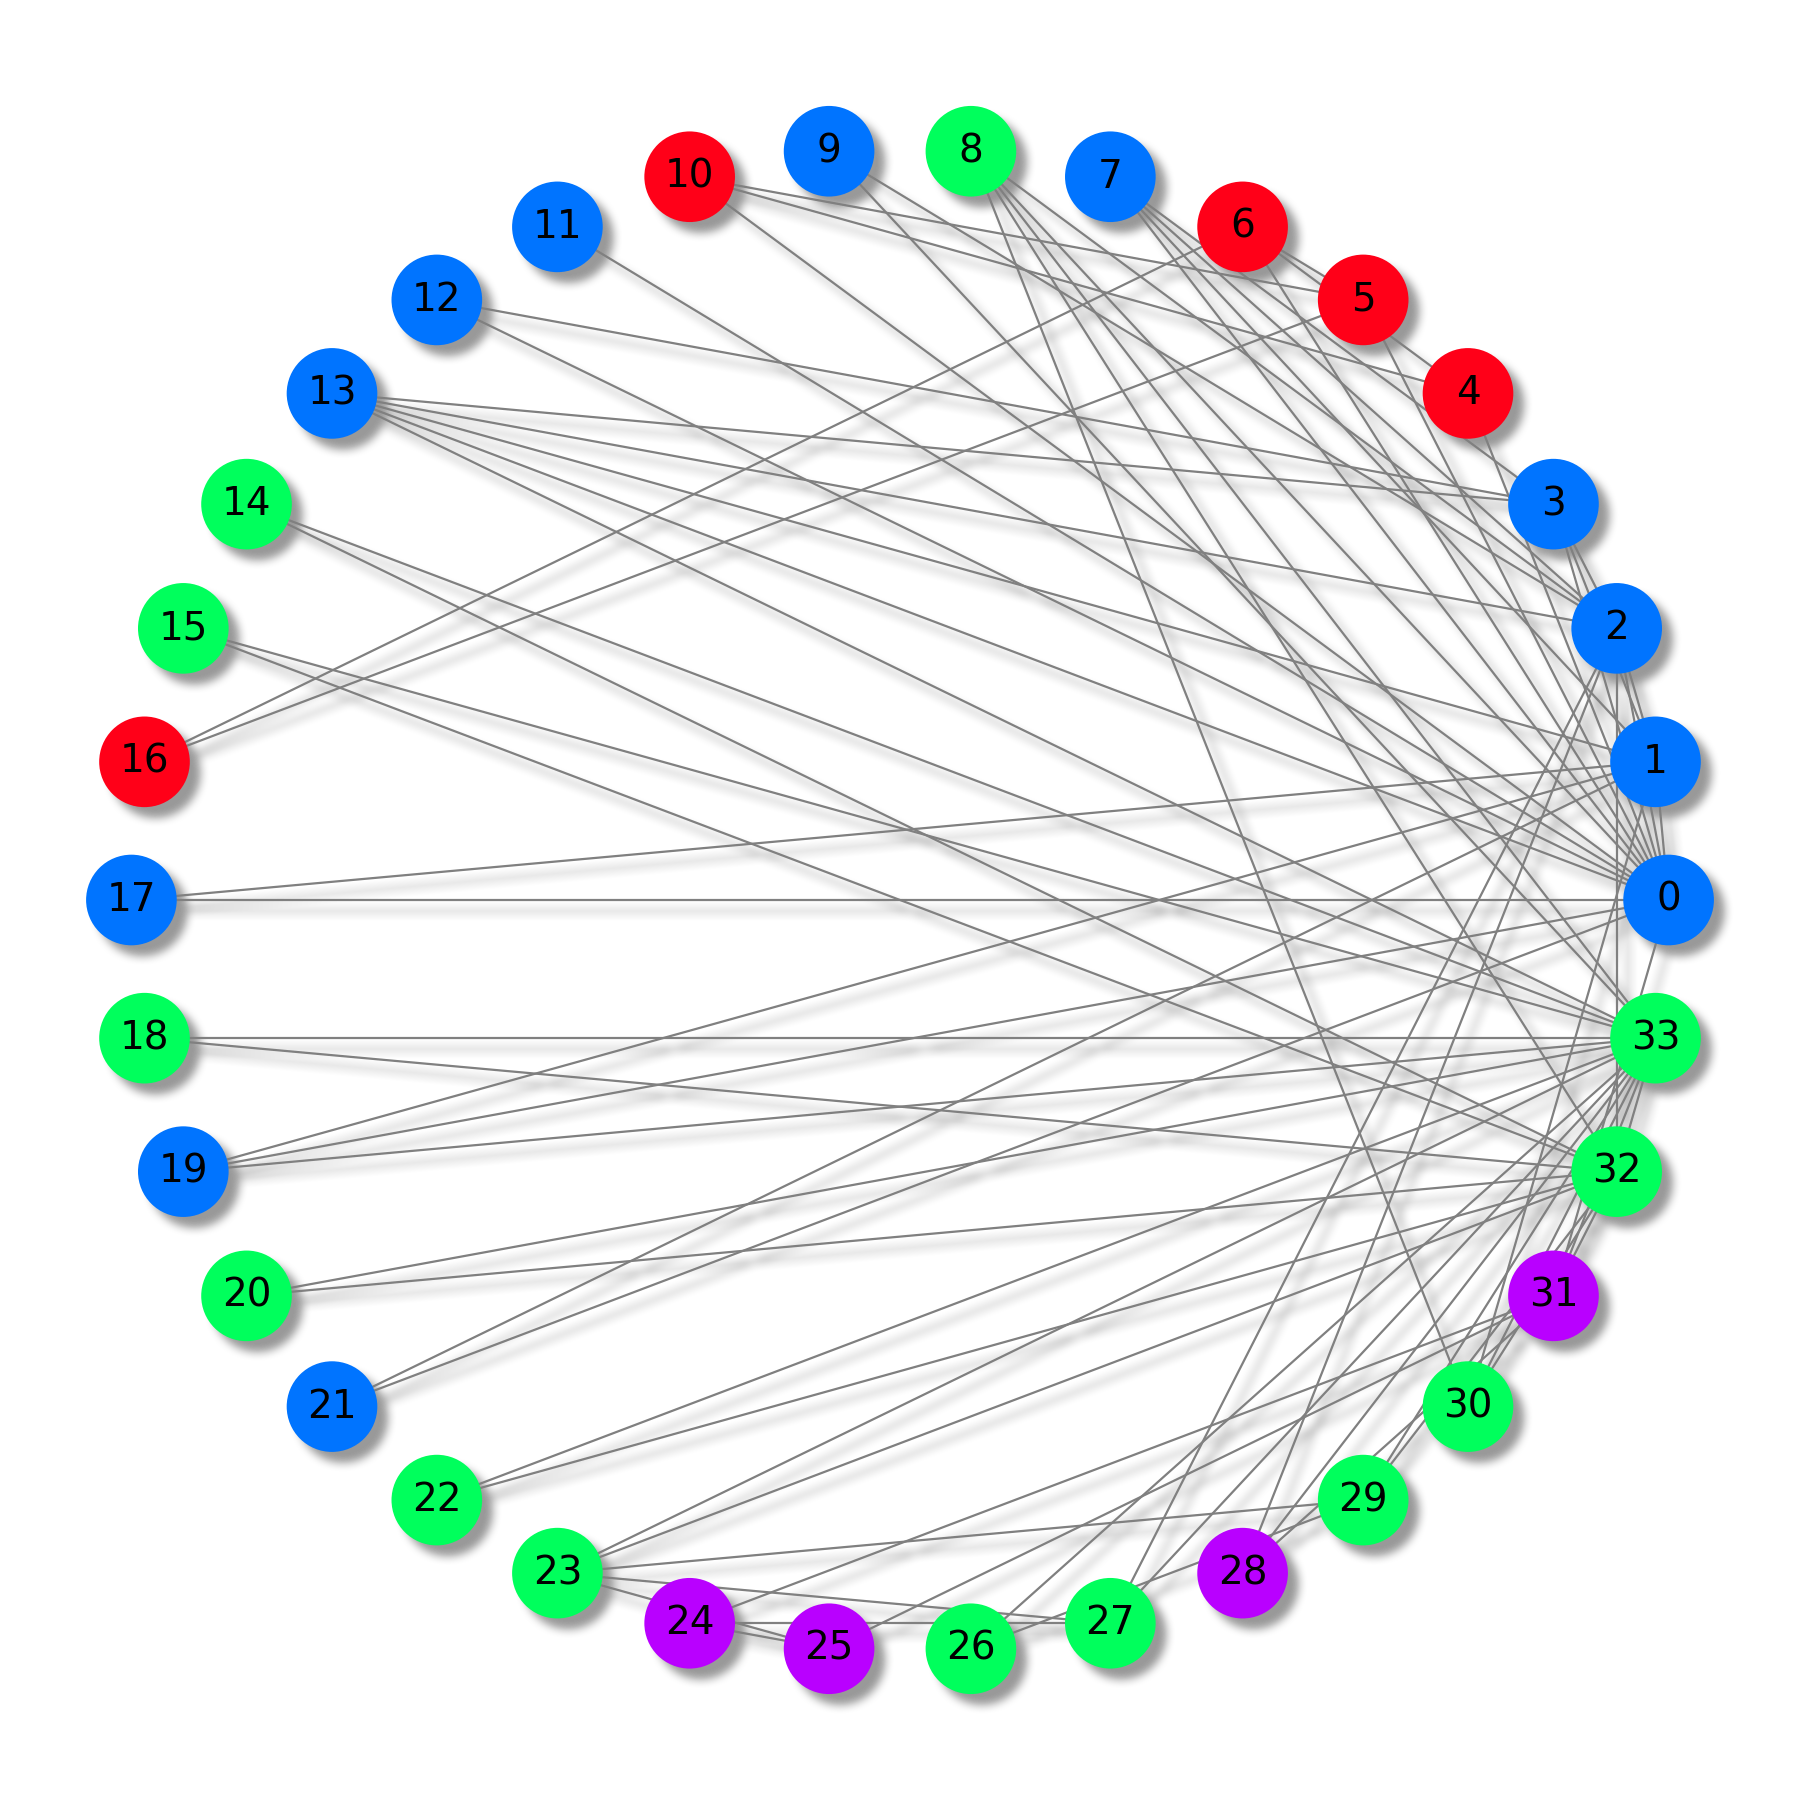

In [ ]:
# Graph Neural Network Introduction
# Link : https://mlabonne.github.io/blog/intrognn/
#

import torch
# Numpy 라이브러리
import numpy as np

# 시각화 라이브러리
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
# 가라데 클럽 데이터 로딩
#

from torch_geometric.datasets import KarateClub

# Import dataset from PyTorch Geometric
dataset = KarateClub()

# 그래프 정보 확인
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'입력 노드 shape :  {dataset[0].x.shape}')
print(f'입력 엣지 shape :  {dataset[0].num_edges}')
print(f'입력 엣지 특성 차원 : {dataset[0].num_edge_features}')
print(f"입력 엣지 유형 수 : {dataset[0].num_edge_features}")

In [ ]:
# 그래프 정보를 살펴 보자. ==> 1개의 그래프 존재
# node : 가라데 클럽의 멤버
# edge : 멤버 간의 연관 관계
# target : 소속된 그룹 (당파???)
#
print(f'Graph: {dataset[0]}')


In [ ]:
data = dataset[0]

# 노드 특성
print(f'x = {data.x.shape}')
print(data.x)

In [ ]:
# 엣지 정보 (대칭적) : COO (COOrdinate list) format
# 방향성이 없으므로   156/2 = 78 개의 연결을 나타낸다
#
print(f'edge_index = {data.edge_index.shape}')
print("data.edge_index == ", data.edge_index)

# print("data.pos_edge_index == ", data.pos_edge_index)

In [ ]:
# 인접 행렬(Adjacency Matrix) 생성
# 0 이 대부분인 matrix
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

In [ ]:
# 훈련 target
# 4개의 그룹으로 나뉘어진다
#
print(f'y = {data.y.shape}')
print(data.y)

In [ ]:
# 4개의 레이블된 노드에서 시작
#
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

In [ ]:
# 그래프 정보 확인
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

In [ ]:
# 그래프 생성
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

그래프 컨볼루션 네트워크 ( GCN : Graph Convolution Network )


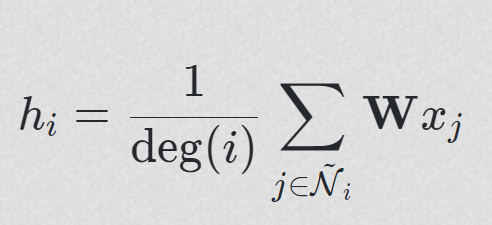

In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv


dim_hidden = 3

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 34 차원의 1 hot encoding이 3 차원으로 ....
        # 3차원은 시각화 가능
        self.gcn = GCNConv(dataset.num_features, dim_hidden)
        self.out = Linear(dim_hidden, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

In [ ]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=5000, repeat=True)
html = HTML(anim.to_html5_video())

In [ ]:
# Node 판별 결과 확인
display(html)

In [ ]:
# 생성되는 Hidden Layer 확인
#
print(f'Final embeddings = {h.shape}')
print(h)

In [ ]:

#
# embed = h[0].detach().cpu().numpy()


# 임베딩된 공간 ( Latent Space )에서 
# 4개의 그룹은 잘 분할되어 있다.
#

embed = h.detach().cpu().numpy()
print("embed.shape == ", embed.shape)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

plt.show()

In [ ]:
%%capture

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

In [ ]:
# embedding 공간 변화 표시
#
display(html)